One challenge with large software packages like fMRIPrep is that there are a ton of choices that must be made, and sometimes not all of those are obvious to the user.  We have [recently realized](https://github.com/nipreps/fmriprep/issues/2477) that one of these choices may have led to suboptimal analysis outcomes, so we are taking this opportunity to surface the issue so that fMRIPrep users are aware of it and can address it appropriately.  

The issue in question regards the application of slice timing correction.  In order to lay out the issue and understand its effects, we first provide a brief introduction to the concept of slice timing correction.  For an even deeper dive into the topic, see [Matthew Brett's teaching page](https://matthew-brett.github.io/teaching/slice_timing.html).

## Why we (might) want slice timing correction

In general, whole-brain fMRI data are collected as a set of two-dimensional slices, each of which is collected at a slightly different time. In this example (taken from our [Handbook of fMRI Data Analysis](https://sites.google.com/site/fmridataanalysis/home)), we see an example of eight slices acquired over the course of a 2 second repetition time.  

![Example of slice timing](slice_timing.png)

In this example the slices are *interleaved*, meaning that every other slice is acquired in a first pass, and then the remaining slices are acquired in a second pass.  It is increasingly common to use multi-slice acquisitions (often referred to as *SMS* or *multiband* acquisitions), where several slices are acquired simultaneously; however, the same points applies, as sets of slices are acquired at different times.

Slice timing becomes an issue when we want to analyze our data in a time-locked way. The most common example is when we want to perform a linear model analysis of task fMRI data.  Let's generate some data for a region of the brain that exhibits a strong response to our stimulus.  We will generate the response a temporal resolution of 0.25 seconds.

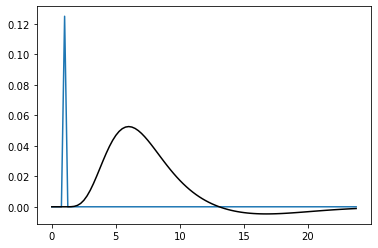

In [1]:
import numpy as np
from spm_hrf import spm_hrf
import matplotlib.pyplot as plt
import pandas as pd 
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import seaborn as sns

def hrf_convolve(resp, time_resolution):
    return(np.convolve(resp, spm_hrf(time_resolution))[:resp.shape[0]])

time_resolution = 0.25  # seconds
time_window = 24  # seconds

resp = np.zeros(int(time_window / time_resolution))
resp[4] = 1
resp_hrf = hrf_convolve(resp, time_resolution)

timeline = np.arange(0, time_window, time_resolution)
plt.plot(timeline, resp/8)
plt.plot(timeline, resp_hrf, 'k')

This hemodynamic response reflects the true underlying response.  Now lets see what the data would look like that were extracted from slice 1 and slice 8 in our example above:

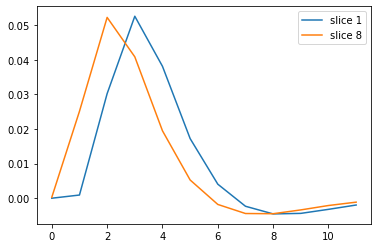

In [2]:
slice_hrf_conv = {}
slice_indices = {}
nslices = 8

for slice in range(nslices):
    slice_indices[slice] = np.arange(slice, resp_hrf.shape[0], nslices)
    slice_hrf_conv[slice] = resp_hrf[slice_indices[slice]]
    
plt.plot(slice_hrf_conv[0])
plt.plot(slice_hrf_conv[7])
plt.legend(['slice 1', 'slice 8'])

The observed responses (reflecting the same underlying brain response) look different from the two slices, because they reflect sampling of different points in time:


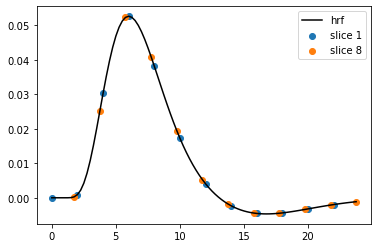

In [3]:
plt.plot(timeline, resp_hrf, 'k')

plt.scatter(slice_indices[0]*time_resolution, resp_hrf[slice_indices[0]])
plt.scatter(slice_indices[7]*time_resolution, resp_hrf[slice_indices[7]])
plt.legend(['hrf', 'slice 1', 'slice 8'])

Now let's see what effect this would have on our ability to detect activation.  Let's say that we present a stimulus 10 times (ever 20 seconds) which causes homogenous activation within a region of interest.  The stimulus is presented for a brief period at the beginning of the acquisition (i.e. during the acquisition of slice 1 in our example above). Here is what the signal might look like (with some noise injected as well, because fMRI data are noisy :-).  Note that this is not meant to be a serious simulation of fMRI data; it is meant to exemplify the pattern of the effects, but the specific values should not be interpreted seriously.

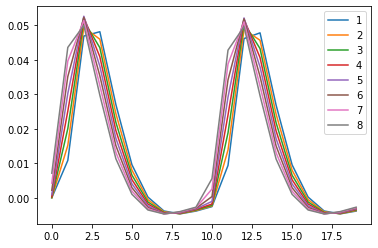

In [4]:
nstim = 10
interval = 20
scanlength = int((nstim * interval) / time_resolution)  # scan length at high resolution

true_onset_times_secs = np.arange(0, nstim*interval, interval).astype(int)

true_onset_times_highres = (true_onset_times_secs/time_resolution).astype(int)

onsets_highres = np.zeros(scanlength)
onsets_highres[true_onset_times_highres] = 1
onsets_convolved_highres = hrf_convolve(onsets_highres, time_resolution)

# plt.plot(onsets_convolved_highres)

# get signal for each slice
nslices = 8
slice_signal = {}
slice_indices = {}

for slice in range(nslices):
    slice_indices[slice] = np.arange(slice, onsets_convolved_highres.shape[0], nslices)
    slice_signal[slice] = onsets_convolved_highres[slice_indices[slice]]
    plt.plot(slice_signal[slice][:20])
    
plt.legend([str(i + 1) for i in range(nslices)])

In [5]:
rng = np.random.default_rng()

def get_noise(scanlength, windowlen, rng=None):
    if rng is None:
        rng = np.random.default_rng(None)
    # add autocorrelated noise - using pandas rolling average to get this
    noise_df = pd.DataFrame({'noise': rng.normal(size = scanlength + windowlen)})
    return(noise_df.noise.rolling(20).sum().to_numpy()[windowlen:])



In [6]:

def sim_data_ols(regressor, signal, beta, window=None, rng=None):
    """
    simulate timeseries and get p-value for regression
    
    inputs: 
    signal: onsets convolved with HRF
    beta: effect size for signal
    window: averaging window for noise, or None for Gaussian IID
    
    returns:
    pvalue for onsets coefficient
    """
    scanlength = signal.shape[0]
    if window is None:
        noise = rng.normal(size=scanlength)
    else:
        noise = get_noise(scanlength, window, rng)
    
    data = signal * beta + noise
    X = sm.add_constant(regressor)
    # use Generalized Least Squares with AR covariance structure
    glsar_model = sm.GLSAR(data, X, 1)
    glsar_results = glsar_model.iterative_fit(1)
    
    return(glsar_results.pvalues[1])

rng = np.random.default_rng()
sim_data_ols(slice_signal[0], slice_signal[0], 1, rng=rng)

0.2623563858341521

In [7]:
sim_results = []
nsims = 1000
rng = np.random.default_rng()

for slc in np.arange(8):
    for beta in np.arange(30, step=2):
        for sim in range(nsims):
            # slice 0 is time-locked to the true regressor so use that as the regressor
            sim_results.append([slc, beta, sim_data_ols(slice_signal[0], slice_signal[slc], beta, rng=rng)])
        
sim_results_df = pd.DataFrame(sim_results, columns=['slice', 'beta', 'pvalue'])

<AxesSubplot:xlabel='beta', ylabel='p_significant'>

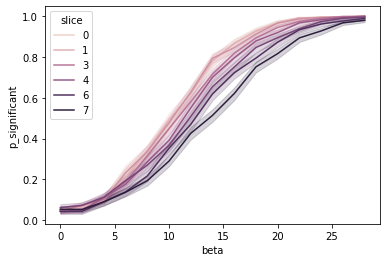

In [8]:
sim_results_df['p_significant'] = sim_results_df.pvalue < .05

sns.lineplot(x='beta', y='p_significant', hue='slice', data=sim_results_df)

This plot shows that the statistical power is substantially lower for slices that are far in time from the slice that is time-locked to the actual onsets.

## How slice time correction works

One could in theory address the slice timing problem by using a different statistical model for each slice, taking into account the slice timing to adjust the onset times used to generate the regressor. However, this assumes that the statistical analysis takes place in the original slice space, whereas some analysis packages spatially smooth and/or transform the data to a standard space prior to analysis.  For this reason, the standard approach is to *resample* the data so that they are temporally aligned.  This is analogous to what we do when we register images, as we are basically reslicing the data into a new reference frame -- only in time, rather than in space.

We can use an interpolation function from the scipy package to interpolate the data from slice 8 into the times of slice 1:

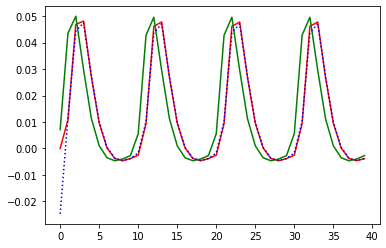

In [9]:
# thanks to https://matthew-brett.github.io/teaching/slice_timing.html
from scipy.interpolate import InterpolatedUnivariateSpline as Interp

lin_interper = Interp(slice_indices[7], slice_signal[7], k=1)
interped_vals = lin_interper(slice_indices[0])

plt.plot(slice_signal[0][:40], 'r')
plt.plot(slice_signal[7][:40], 'g')
plt.plot(interped_vals[:40], 'b:')

The raw data from slice 8 (in green) are misaligned with slice 1 (in red), but the aligned signal from slice 7 (in blue dots) overlaps closely with the slice 1 signal, except for some error in the very beginning (which is common with interpolation).

## Potential reasons to avoid slice timing correction

Historically some labs have avoided the application of STC for a couple of reasons.  The first is that it can interact with motion correction; in principle it would be best to apply slice timing correction and motion correction within a single 4D interpolation, but tools for this have not been available.  Another reason is that the interpolation methods (such as sinc interpolation) that have historically been used for STC can tend to spread artifacts (such as strong motion artifacts) across the scan, causing greater harm than the problem they are meaning to solve.  However, in general it is now considered a best practice to perform STC prior to fMRI analysis unless there are specific reasons not to do so for a particular study.

## Slice timing in fMRIprep

Slice timing correction is enabled by default in fMRIprep and is performed using the AFNI [3dTshift function](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dTshift.html).  This function takes an argument called *-tzero* that specifies which slice time to register to, which defaults to "the average of the 'tpattern' values (either from the dataset header or from the -tpattern option)" - that is, the middle slice in time.  fMRIPrep inherits this default, which is made clear in the documentation ([here](https://fmriprep.org/en/stable/workflows.html#slice-time-correction) and [here](https://raw.githubusercontent.com/oesteban/fmriprep/38a63e9504ab67812b63813c5fe9af882109408e/docs/_static/fmriprep-workflow-all.png)), but the importance of this point may not have been sufficiently clear to users: Namely, if one uses data processed in this way without adjusting the timing of the event onsets, then the model will be misaligned with the data.  

In practice, the ultimate result of analyzing fMRIPrep data (processed with the default slice timing option enabled) without adjusting one's event onsets is that the model will have a TR/2 offset from the true onsets, which are generally specified with regard to the beginning of the image acquisition.  This is functionally equivalent to not doing slice timing correction at all, since the average timing error across slices will be TR/2. It's actually slightly better than not doing slice timing correction at all, because at least in this case the error is the same across all slices, whereas when STC is not applied the error will vary depending on the slice, leading to differences in sensitivity across slices.  However, it is clearly *worse* than analyzing the data using onsets that have been shifted in time by TR/2.  

## What should I do if I analyzed my data without adjusting event times?

The answer is probably *nothing*.  Given that researchers regularly publish results without performing slice timing correction, and that the result of analyzing fMRIprep-ed data without adjusting the event times is just slightly better than using no STC, there is no reason to think that such an analysis is any worse than many other published analyses.  In particular, while this analysis approach will likely reduce statistical power, it is highly unlikely to result in false positives.  Having said that, if you are in the midst of analyses, you should definitely fix your onsets (i.e. delay them by TR/2) so that they match the STC target.  This will help maximize your statstical power to detect activations.  